In [1]:
!pip list |grep hydra

hydra-core                0.11.3    


### kerasからplへの移行 dataloader編

### 必要な機能

#### make_path_list
- dirから学習pathを取り出す

#### dataset
input:path_list
output:data,
- 学習pathからデータをロードして、datatransformを元に変形する
- anotationとセットで返す。必要なら、座標もともに返す


#### datatransform
- 関数を何個か受け取って処理を行う。

#### dataloader
- dataset,datatransformを合体させて、バッチで返す 

In [5]:
import torch
import torch.utils.data as data
from torchvision import transforms
import pathlib
import pandas as pd
from pathlib import Path
import numpy as np 
import sys 
import os
import matplotlib.pyplot as plt




## DataLoader

In [6]:
DATA_DIR = '/home/higuchi/ssd/kits19/data'
train_patch = 'tumor_48x48x16'
val_patch = 'tumor_60x60x20'
train_ids=['001','002']
val_ids=['001','002']

class DataPathMaker():
    '''
    DataSetに渡すpath_listを作るためのDataFrameを作る
    今後の展望として、統計量を持ったDFを渡してその条件でlistを変えるようにする。
    '''
    # TODO:文字列の除去
    def __init__(self, data_dir, patch_dir_name='patch'):
        self.data_dir = pathlib.Path(data_dir)
        self.patch_dir_name = patch_dir_name
        

    def create_dataframe(self, id_list):
        data = []
        for patient_id in id_list:
            # TODO: case_00の部分もyamlから渡せるようにしたほうがよい
            patient_dir = self.data_dir / f'case_00{patient_id}' / self.patch_dir_name
            images = sorted(patient_dir.glob('patch_image_*.npy'))
            labels = sorted(patient_dir.glob('patch_no_onehot_*.npy'))
            if len(images) == 1 or len(labels) == 0:
                print(f'{patient_id} is no data')
            for image, label in zip(images, labels):
                data.append(['image', patient_id, image])
                data.append(['label', patient_id, label])
        return pd.DataFrame(data, columns=['type', 'id', 'path'])


train_path_df = DataPathMaker(DATA_DIR, patch_dir_name=train_patch).create_dataframe(train_ids)
val_path_df = DataPathMaker(DATA_DIR, patch_dir_name=val_patch).create_dataframe(val_ids)

train_im_list = train_path_df[train_path_df['type']=='image']['path'].astype(str).values
val_im_list = train_path_df[train_path_df['type']=='image']['path'].astype(str).values

train_lb_list = train_path_df[train_path_df['type']=='label']['path'].astype(str).values
val_lb_list = train_path_df[train_path_df['type']=='label']['path'].astype(str).values


In [7]:
# パッケージのimport
import torch
from torchvision import transforms
from PIL import Image, ImageOps, ImageFilter
import numpy as np


class Compose(object):
    """引数transformに格納された変形を順番に実行するクラス
       対象画像とアノテーション画像を同時に変換させます。 
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, anno_class_img):
        for t in self.transforms:
            img, anno_class_img = t(img, anno_class_img)
        return img, anno_class_img


class Scale(object):
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, img, anno_class_img):

        width = img.size[0]  # img.size=[幅][高さ]
        height = img.size[1]  # img.size=[幅][高さ]

        # 拡大倍率をランダムに設定
        scale = np.random.uniform(self.scale[0], self.scale[1])

        scaled_w = int(width * scale)  # img.size=[幅][高さ]
        scaled_h = int(height * scale)  # img.size=[幅][高さ]

        # 画像のリサイズ
        img = img.resize((scaled_w, scaled_h), Image.BICUBIC)

        # アノテーションのリサイズ
        anno_class_img = anno_class_img.resize(
            (scaled_w, scaled_h), Image.NEAREST)

        # 画像を元の大きさに
        # 切り出し位置を求める
        if scale > 1.0:
            left = scaled_w - width
            left = int(np.random.uniform(0, left))

            top = scaled_h-height
            top = int(np.random.uniform(0, top))

            img = img.crop((left, top, left+width, top+height))
            anno_class_img = anno_class_img.crop(
                (left, top, left+width, top+height))

        else:
            # input_sizeよりも短い辺はpaddingする
            p_palette = anno_class_img.copy().getpalette()

            img_original = img.copy()
            anno_class_img_original = anno_class_img.copy()

            pad_width = width-scaled_w
            pad_width_left = int(np.random.uniform(0, pad_width))

            pad_height = height-scaled_h
            pad_height_top = int(np.random.uniform(0, pad_height))

            img = Image.new(img.mode, (width, height), (0, 0, 0))
            img.paste(img_original, (pad_width_left, pad_height_top))

            anno_class_img = Image.new(
                anno_class_img.mode, (width, height), (0))
            anno_class_img.paste(anno_class_img_original,
                                 (pad_width_left, pad_height_top))
            anno_class_img.putpalette(p_palette)

        return img, anno_class_img


class RandomRotation(object):
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, img, anno_class_img):

        # 回転角度を決める
        rotate_angle = (np.random.uniform(self.angle[0], self.angle[1]))

        # 回転
        img = img.rotate(rotate_angle, Image.BILINEAR)
        anno_class_img = anno_class_img.rotate(rotate_angle, Image.NEAREST)

        return img, anno_class_img

In [8]:
from tensorflow.keras.utils import Sequence, to_categorical
class KitsDataSet(data.Dataset):
    '''
    loadした後のデータの処理のみを行う。
    input:train,val,testのdata_list(絞り込み済み) & label_list
    '''
    # TODO: ラベルが重ねってる部分の処理(binaly_labels)
    # TODO: Augment_code
    def __init__(self, img_list, label_list, transform, phase='train'):
        self.img_list = img_list
        self.label_list = label_list
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,index):
        im = np.load(self.img_list[index])
        lb = np.load(self.label_list[index])
    
        if self.transform:
            im, lb = self.transform(im, lb, self.phase)

        # B,D,C,H,Wに変換する
        # im = im.permute(3, 2, 0, 1)
        # im = np.transpose(im, (2, 3, 0, 1))
        im = np.transpose(im, (3, 2, 0, 1))


        # B,C,H,Wに変換する
        # lb = lb.permute(2, 0, 1)

        #numpy ver
        lb = to_categorical(lb, num_classes=3)
        # lb = np.transpose(lb, (2, 3, 0, 1))
        lb = np.transpose(lb, (3, 2, 0, 1))

        return im, lb 




tr_DS = KitsDataSet(train_im_list,train_lb_list,phase='train', transform = None)
val_DS = KitsDataSet(val_im_list,val_lb_list,phase='val', transform = None)

aa
print(tr_DS.__getitem__(0)[1].shape)



(3, 16, 48, 48)


In [9]:
aanet_shape=[8, 1, 16, 48, 48]

In [10]:
batch_size = 8
train_dl = data.DataLoader(tr_DS, batch_size = batch_size)
val_dl = data.DataLoader(val_DS, batch_size = batch_size)

dataloaders_dict = {
    "train": train_dl,
    "val": val_dl
}

batch_iterator = iter(dataloaders_dict["val"])

images, labels = next(batch_iterator)

print(images.size())
print(labels.size())

torch.Size([8, 1, 16, 48, 48])
torch.Size([8, 3, 16, 48, 48])


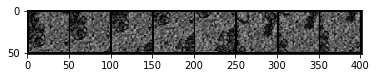

In [8]:
import torchvision
grid = torchvision.utils.make_grid\
(images[:,:,1,:, :].to(torch.int16).abs())

# grid = transforms.ToPILImage()(grid)grid

plt.imshow(grid.permute(1,2,0).numpy())


## Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch,dropout=True,weight_init=True):
        self.dropout=dropout
        super(double_conv, self).__init__()
        conv1_out=out_ch//2

        if conv1_out < in_ch:
                conv1_out = in_ch

        self.dropout_layer=nn.Dropout3d(p=0.5)
        self.conv = nn.Sequential(
            #in,out,kernel_size,padding
            nn.Conv3d(in_ch, conv1_out, 3, padding=1),
            nn.BatchNorm3d(conv1_out),
            nn.ReLU(inplace=True),
            nn.Conv3d(conv1_out, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
        )

        if weight_init:
            self.conv.apply(self.init_weights)
            
    @staticmethod
    def init_weights(m):
        if type(m) == nn.Conv3d:
            torch.nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        x = self.conv(x)
        if self.dropout:
            x=self.dropout_layer(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch,dropout=True)

    def forward(self, x):
        x = self.conv(x)
        return x




class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool3d((2,2,2)),
            double_conv(in_ch, out_ch,dropout=True)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False,init_weights=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_ch // 2, in_ch // 2, 2, stride=2)
        if init_weights:
            self.up.apply(self.init_weights)

        self.conv = double_conv(int(in_ch*3/4), out_ch,dropout=False)
    
    @staticmethod
    def init_weights(m):
        if type(m) == nn.ConvTranspose3d:
            torch.nn.init.kaiming_normal_(m.weight)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffZ = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]
        diffY = x1.size()[4] - x2.size()[4]
        x2 = F.pad(x2, (diffZ // 2, int(diffZ / 2),
                        diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x




class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv3d(in_ch, out_ch, 1)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv(x)
        x= self.softmax(x)
        
        return x



class UNet3D(nn.Module):
    def __init__(self, input_shape, n_classes):
        super(UNet3D, self).__init__()
        self.in_ch=input_shape[1]
        self.inc = inconv(self.in_ch, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        # x5 = self.down4(x4)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        # x = self.up4(x, x1)
        x = self.outc(x)
        return x


In [13]:
images.type()

'torch.DoubleTensor'

In [14]:
print(dummy_img.type(),images.type())

torch.cuda.FloatTensor torch.DoubleTensor


In [17]:
c_images=images.to(device)
print(c_images.type())
print(c_images.float().type())


torch.cuda.DoubleTensor
torch.cuda.FloatTensor


In [11]:
net_shape = [8, 1, 16, 48, 48]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

unet = UNet3D(net_shape, 3)
unet.to(device)
print(device)

dummy_img = torch.rand(net_shape).to(device)

output = unet(dummy_img)
print('output:', output)

   [0.3463, 0.2841, 0.2755,  ..., 0.2333, 0.2830, 0.2267]],

          [[0.2664, 0.1908, 0.2816,  ..., 0.2671, 0.2580, 0.2097],
           [0.2415, 0.3773, 0.3173,  ..., 0.3034, 0.1938, 0.3605],
           [0.2776, 0.3662, 0.3566,  ..., 0.2320, 0.2320, 0.2529],
           ...,
           [0.3107, 0.3007, 0.3591,  ..., 0.3251, 0.1959, 0.2953],
           [0.2530, 0.3249, 0.2722,  ..., 0.3713, 0.3286, 0.2381],
           [0.3790, 0.4134, 0.4345,  ..., 0.3224, 0.2033, 0.2436]],

          [[0.2339, 0.2655, 0.2710,  ..., 0.2952, 0.1794, 0.2149],
           [0.2679, 0.3111, 0.4698,  ..., 0.3260, 0.2305, 0.2550],
           [0.2772, 0.2491, 0.3271,  ..., 0.2206, 0.3725, 0.2299],
           ...,
           [0.3040, 0.1544, 0.2446,  ..., 0.3122, 0.2453, 0.2936],
           [0.3906, 0.2954, 0.2928,  ..., 0.3262, 0.3101, 0.3325],
           [0.3486, 0.3458, 0.4111,  ..., 0.2645, 0.3170, 0.2702]],

          ...,

          [[0.1845, 0.3023, 0.2052,  ..., 0.1878, 0.2264, 0.2047],
           [0.36

### Trainer

In [3]:
import pytorch_lightning as pl

from pytorch_lightning.logging import MLFlowLogger, TensorBoardLogger